# Анализ покупок и пользователей e-commerce

Онлайн магазин хочет проанализировать совершенные покупки и пользователей, оценить эффективность рекламной кампании и определить способы маркетинговых коммуникаций для разных сегментов покупателей.

**Задача.** Изучить данные и определить количество пользователей, которые совершили покупку только один раз, вывести детализацию причин по недоставленным заказам, определить среднее количество покупок в неделю для каждого пользователя, провести когортный анализ и RFM-сегментацию.

**Описание данных**\
customer_id — позаказный идентификатор пользователя\
customer_unique_id —  уникальный идентификатор пользователя  (аналог номера паспорта)\
customer_zip_code_prefix —  почтовый индекс пользователя\
customer_city —  город доставки пользователя\
customer_state —  штат доставки пользователя

order_id —  уникальный идентификатор заказа (номер чека)\
customer_id —  позаказный идентификатор пользователя\
order_status —  статус заказа\
order_purchase_timestamp —  время создания заказа\
order_approved_at —  время подтверждения оплаты заказа\
order_delivered_carrier_date —  время передачи заказа в логистическую службу\
order_delivered_customer_date —  время доставки заказа\
order_estimated_delivery_date —  обещанная дата доставки

created —  создан\
approved —  подтверждён\
invoiced —  выставлен счёт\
processing —  в процессе сборки заказа\
shipped —  отгружен со склада\
delivered —  доставлен пользователю\
unavailable —  недоступен\
canceled —  отменён

order_id —  уникальный идентификатор заказа (номер чека)\
order_item_id —  идентификатор товара внутри одного заказа\
product_id —  ид товара (аналог штрихкода)\
seller_id — ид производителя товара\
shipping_limit_date —  максимальная дата доставки продавцом для передачи заказа партнеру по логистике\
price —  цена за единицу товара\
freight_value —  вес товара

In [299]:
import pandas as pd
import datetime as dt
from datetime import timedelta
import dateutil.relativedelta as relativedelta
from calendar import monthrange
import calendar
import numpy as np
import matplotlib.pyplot as plt
import matplotlib as mpl
from operator import attrgetter
import seaborn as sns
import matplotlib.colors as mcolors

### Обзор данных

In [300]:
customers = pd.read_csv('/Users/kristinasharoyko/Documents/data_for/archive/olist_customers_dataset.csv')
customers.head(3)

,customer_id,customer_unique_id,customer_zip_code_prefix,customer_city,customer_state
0,06b8999e2fba1a1fbc88172c00ba8bc7,861eff4711a542e4b93843c6dd7febb0,14409,franca,SP
1,18955e83d337fd6b2def6b18a428ac77,290c77bc529b7ac935b93aa66c333dc3,9790,sao bernardo do campo,SP
2,4e7b3e00288586ebd08712fdd0374a03,060e732b5b29e8181a18229c7b0b2b5e,1151,sao paulo,SP


In [301]:
customers.shape

(99441, 5)

In [302]:
customers.dtypes

customer_id                 object
customer_unique_id          object
customer_zip_code_prefix     int64
customer_city               object
customer_state              object
dtype: object

In [303]:
orders = pd.read_csv('/Users/kristinasharoyko/Documents/data_for/archive/olist_orders_dataset.csv', \
                     parse_dates = ['order_purchase_timestamp', 'order_approved_at', 'order_delivered_carrier_date',
                                    'order_delivered_customer_date', 'order_estimated_delivery_date'])
orders.head(3)

,order_id,customer_id,order_status,order_purchase_timestamp,order_approved_at,order_delivered_carrier_date,order_delivered_customer_date,order_estimated_delivery_date
0,e481f51cbdc54678b7cc49136f2d6af7,9ef432eb6251297304e76186b10a928d,delivered,2017-10-02 10:56:33,2017-10-02 11:07:15,2017-10-04 19:55:00,2017-10-10 21:25:13,2017-10-18
1,53cdb2fc8bc7dce0b6741e2150273451,b0830fb4747a6c6d20dea0b8c802d7ef,delivered,2018-07-24 20:41:37,2018-07-26 03:24:27,2018-07-26 14:31:00,2018-08-07 15:27:45,2018-08-13
2,47770eb9100c2d0c44946d9cf07ec65d,41ce2a54c0b03bf3443c3d931a367089,delivered,2018-08-08 08:38:49,2018-08-08 08:55:23,2018-08-08 13:50:00,2018-08-17 18:06:29,2018-09-04


In [304]:
orders.shape

(99441, 8)

In [305]:
orders.dtypes

order_id                                 object
customer_id                              object
order_status                             object
order_purchase_timestamp         datetime64[ns]
order_approved_at                datetime64[ns]
order_delivered_carrier_date     datetime64[ns]
order_delivered_customer_date    datetime64[ns]
order_estimated_delivery_date    datetime64[ns]
dtype: object

In [306]:
orders.order_status.nunique()

8

In [307]:
items = pd.read_csv('/Users/kristinasharoyko/Documents/data_for/archive/olist_order_items_dataset.csv', \
                   parse_dates = ['shipping_limit_date'])
items.head(3)

,order_id,order_item_id,product_id,seller_id,shipping_limit_date,price,freight_value
0,00010242fe8c5a6d1ba2dd792cb16214,1,4244733e06e7ecb4970a6e2683c13e61,48436dade18ac8b2bce089ec2a041202,2017-09-19 09:45:35,58.9,13.29
1,00018f77f2f0320c557190d7a144bdd3,1,e5f2d52b802189ee658865ca93d83a8f,dd7ddc04e1b6c2c614352b383efe2d36,2017-05-03 11:05:13,239.9,19.93
2,000229ec398224ef6ca0657da4fc703e,1,c777355d18b72b67abbeef9df44fd0fd,5b51032eddd242adc84c38acab88f23d,2018-01-18 14:48:30,199.0,17.87


In [308]:
items.shape

(112650, 7)

In [309]:
items.dtypes

order_id                       object
order_item_id                   int64
product_id                     object
seller_id                      object
shipping_limit_date    datetime64[ns]
price                         float64
freight_value                 float64
dtype: object

In [310]:
items.nunique()

order_id               98666
order_item_id             21
product_id             32951
seller_id               3095
shipping_limit_date    93318
price                   5968
freight_value           6999
dtype: int64

Данные соответствуют описанию. **Покупкой** будем считать доставленный заказ, тк он уже принес прибыль, не был отменен/недоступен/в процессе доставки

### Количество пользователей, которые совершили покупку только один раз

Посмотрим количество уникальных customer_id и customer_unique_id в customers\
customer_unique_id - это точно какой-то уникальный номер пользователя, customer_id пока не очень понятно что

In [311]:
customers.nunique()

customer_id                 99441
customer_unique_id          96096
customer_zip_code_prefix    14994
customer_city                4119
customer_state                 27
dtype: int64

customer_id есть в orders, для каждого order_id есть только один customer_id

In [312]:
orders.nunique()

order_id                         99441
customer_id                      99441
order_status                         8
order_purchase_timestamp         98875
order_approved_at                90733
order_delivered_carrier_date     81018
order_delivered_customer_date    95664
order_estimated_delivery_date      459
dtype: int64

In [313]:
orders.query("order_status == 'shipped'").head(1)

,order_id,customer_id,order_status,order_purchase_timestamp,order_approved_at,order_delivered_carrier_date,order_delivered_customer_date,order_estimated_delivery_date
44,ee64d42b8cf066f35eac1cf57de1aa85,caded193e8e47b8362864762a83db3c5,shipped,2018-06-04 16:44:48,2018-06-05 04:31:18,2018-06-05 14:32:00,NaT,2018-06-28


In [314]:
orders.query("order_status == 'created'").head(1)

,order_id,customer_id,order_status,order_purchase_timestamp,order_approved_at,order_delivered_carrier_date,order_delivered_customer_date,order_estimated_delivery_date
7434,b5359909123fa03c50bdb0cfed07f098,438449d4af8980d107bf04571413a8e7,created,2017-12-05 01:07:52,NaT,NaT,NaT,2018-01-11


По структуре дф можно сделать вывод, что для каждого заказа order_id каждый раз создается новый customer_id, который соответствует одному customer_unique_id, а order_status перезаписывается при изменении статуса заказа, при этом еще добавляется время в колонки order_purchase_timestamp, order_approved_at, order_delivered_carrier_date, order_delivered_customer_date, когда статус изменился.\
В orders у нас просто все заказы, посчитаем только те покупки, которые были доставлены. 

In [315]:
#объединим orders и customers
orders_customers = orders.merge(customers, how = 'inner', on = 'customer_id' )


orders_customers.head(3)

,order_id,customer_id,order_status,order_purchase_timestamp,order_approved_at,order_delivered_carrier_date,order_delivered_customer_date,order_estimated_delivery_date,customer_unique_id,customer_zip_code_prefix,customer_city,customer_state
0,e481f51cbdc54678b7cc49136f2d6af7,9ef432eb6251297304e76186b10a928d,delivered,2017-10-02 10:56:33,2017-10-02 11:07:15,2017-10-04 19:55:00,2017-10-10 21:25:13,2017-10-18,7c396fd4830fd04220f754e42b4e5bff,3149,sao paulo,SP
1,53cdb2fc8bc7dce0b6741e2150273451,b0830fb4747a6c6d20dea0b8c802d7ef,delivered,2018-07-24 20:41:37,2018-07-26 03:24:27,2018-07-26 14:31:00,2018-08-07 15:27:45,2018-08-13,af07308b275d755c9edb36a90c618231,47813,barreiras,BA
2,47770eb9100c2d0c44946d9cf07ec65d,41ce2a54c0b03bf3443c3d931a367089,delivered,2018-08-08 08:38:49,2018-08-08 08:55:23,2018-08-08 13:50:00,2018-08-17 18:06:29,2018-09-04,3a653a41f6f9fc3d2a113cf8398680e8,75265,vianopolis,GO


#### Рассчет доставленных покупкок для каждого уникального пользователя и сколько пользователей сколько покупок совершили

In [316]:
orders_customers.query("order_status == 'delivered'")\
                .groupby('customer_unique_id', as_index=False)\
                .agg({'customer_id':'count'}).value_counts('customer_id')

customer_id
1     90557
2      2573
3       181
4        28
5         9
6         5
7         3
9         1
15        1
dtype: int64

#### Процент пользователей, которые совершили покупку только один раз

In [317]:
order_count_by = orders_customers[['order_id', 'customer_unique_id']].groupby('customer_unique_id', as_index=False).agg({'order_id':'count'})
round(order_count_by.query("order_id==1").customer_unique_id.count()/order_count_by.customer_unique_id.count() *100, 1)

96.9

**90557 пользователей совершили покупку только один раз, это 96.9%**

### Детализация причин недоставленных заказов

In [318]:
# количество месяцев между первым и последним заказом в исходных данных
d1 = orders['order_purchase_timestamp'].min()
d2 = orders['order_purchase_timestamp'].max()
delta = relativedelta.relativedelta(d2, d1)
delta_months = delta.years*12 + delta.months

# количество недоставленных заказов
not_delivered_count = orders.query("order_status != 'delivered'").groupby('order_status', as_index = False)\
                        .agg({'order_id':'count'})\
                        .rename(columns = {'order_id':'count'})\
                        .sort_values('count', ascending = False)

**Количество недоставленных заказов в среднем в месяц по все причинам**  (avg_month), в том числе заказы, которые пока еще не доставлены. Категории, которые не находятся в процессе доставки, это canceled и unavailable, то есть те, которые точно не будут доставлены. Остальные пока в состоянии неопределенности, нужно проследить после.

In [319]:
not_delivered_count['avg_month'] = not_delivered_count['count'] / delta_months
not_delivered_count

,order_status,count,avg_month
5,shipped,1107,44.28
1,canceled,625,25.00
6,unavailable,609,24.36
3,invoiced,314,12.56
4,processing,301,12.04
2,created,5,0.20
0,approved,2,0.08


### Среднее количество покупок в неделю

In [320]:
#добавим к заказам информацию об уникальных покупателях, учтем только доставленные покупки
orders_customers = orders[orders['order_status'] == 'delivered'][['order_id', 'customer_id', 'order_purchase_timestamp']]\
                    .merge(customers[['customer_id', 'customer_unique_id']])\
                    .sort_values('order_purchase_timestamp')

# количество недель в месяце совершения покупки
orders_customers['week_in_month'] = orders_customers['order_purchase_timestamp']\
                                    .apply(lambda x: calendar.mdays[x.month]/7)
# добавим месяц покупки и год покупки
orders_customers['month'] = orders_customers.order_purchase_timestamp.dt.month
orders_customers['year'] = orders_customers.order_purchase_timestamp.dt.year

# количество покупок за каждый месяц для каждого уникального пользователя
orders_customers_count = orders_customers.groupby(['customer_unique_id', 'year', 'month', 'week_in_month'], as_index = False)\
                .agg({'order_id':'count'})\
                .rename(columns = {'order_id':'order_count'})

#добавим столбец со средним количеством покупок в неделю по каждому месяцу
orders_customers_count['avg_week'] = orders_customers_count['order_count'] /orders_customers_count['week_in_month']

#итоговая таблица
orders_customers_count.sort_values(['year', 'month'])

,customer_unique_id,year,month,week_in_month,order_count,avg_week
48814,830d5b7aaa3b6f1e9ad63703bec97d23,2016,9,4.285714,1,0.233333
72,0032c76b20340da25249092a268ce66c,2016,10,4.428571,1,0.225806
732,01f156677184504063bd19739f924af1,2016,10,4.428571,1,0.225806
2298,0636d30c77f0f9cfad81f1c9b58c791f,2016,10,4.428571,1,0.225806
2494,06bdfbbe1857c3c925ec81abfb1c9666,2016,10,4.428571,1,0.225806
...,...,...,...,...,...,...
95117,ffc39051848c3ef2be36d1513aa3ad17,2018,8,4.428571,1,0.225806
95120,ffc4e1cd8aa220763480d0a18157c45d,2018,8,4.428571,1,0.225806
95149,ffe204b1bb8026741b839085b2fd10f2,2018,8,4.428571,1,0.225806
95169,ffec490ab531184a483efe2eedd68908,2018,8,4.428571,1,0.225806


Общее среднее всех покупателей

In [321]:
orders_customers_count['avg_week'].mean()

0.2332925225027247

### Когортный анализ. Определить когорту с наибольшим retention в период на 3-й месяц

Функция для построения тепловой карты retention.

In [322]:
def cohort_heatmap(start='2017-01', end='2017-12'):
    
    # таблица с доставленными заказами и уникальными пользователями
    df = orders[orders['order_status'] == 'delivered'][['customer_id', 'order_purchase_timestamp']]\
                    .merge(customers[['customer_id', 'customer_unique_id']], how = 'left', on = 'customer_id' )

    # создаем cohort(указывает ежемесячную когорту - дата первой покупки)
    df['order_month'] = df['order_purchase_timestamp'].dt.to_period('M')
    
    # order_month(месяц покупки)
    df['cohort'] = df.groupby('customer_unique_id')['order_purchase_timestamp'] \
                     .transform('min') \
                     .dt.to_period('M') 
    
    # количество уникальных клиентов в каждой когорте 
    df_cohort = df.groupby(['cohort', 'order_month']) \
                  .agg(n_customers=('customer_unique_id', 'nunique')) \
                  .reset_index(drop=False)
    
    # количество периодов между месяцем когорты и месяцем покупки
    df_cohort['period_number'] = (df_cohort.order_month - df_cohort.cohort).apply(attrgetter('n'))

    # сводная таблица
    cohort_pivot = df_cohort.pivot_table(index = 'cohort',
                                         columns = 'period_number',
                                         values = 'n_customers')\
                            .query("cohort >= @start & cohort <= @end")
    cohort_size = cohort_pivot.iloc[:,0]
    
    # расчет retention
    retention_matrix = cohort_pivot.divide(cohort_size, axis = 0).query("cohort >= @start & cohort <= @end")

    # настройки heatmap
    with sns.axes_style("white"):
        fig, ax = plt.subplots(1, 2, figsize=(25, 10), sharey=True, gridspec_kw={'width_ratios': [1, 13]})

        # retention matrix
        sns.heatmap(retention_matrix, 
                    mask=retention_matrix.isnull(), 
                    annot=True, 
                    fmt = '.1g', 
                    cmap='RdYlGn',
                    vmin=0.0,vmax=0.009,
                    ax=ax[1])
        ax[1].set_title('Monthly Cohorts: User Retention', fontsize=16)
        ax[1].set(xlabel='# of periods',
                  ylabel='')

        # cohort size
        cohort_size_df = pd.DataFrame(cohort_size).rename(columns={0: 'cohort_size'})
        white_cmap = mcolors.ListedColormap(['white'])
        sns.heatmap(cohort_size_df, 
                    annot=True, 
                    cbar=False, 
                    fmt='g', 
                    cmap=white_cmap, 
                    ax=ax[0])
        ax[0].set_yticklabels(ax[0].get_yticklabels(),rotation = 0)           
        fig.tight_layout()

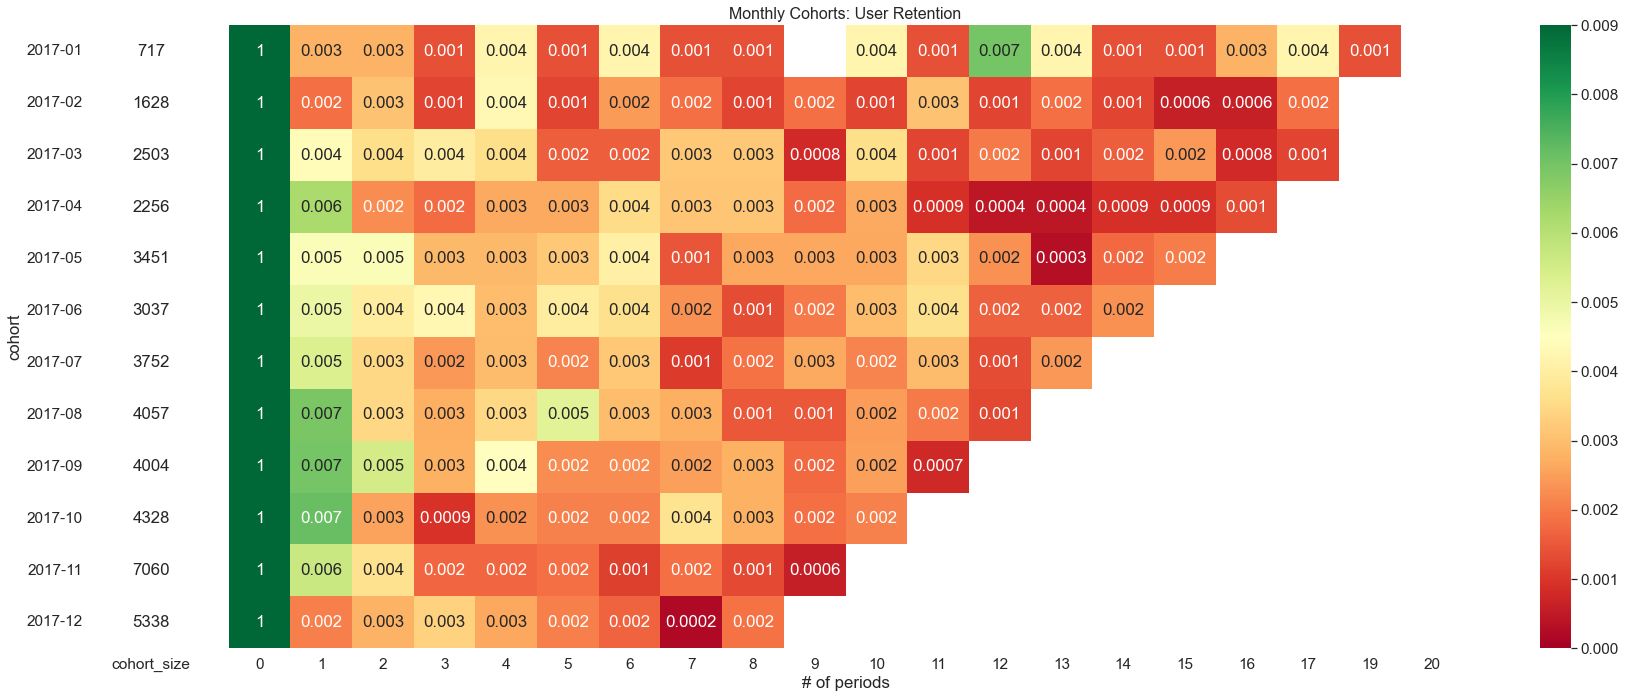

In [323]:
cohort_heatmap()

Максимальный retention на 3-й месяц для когорты

In [324]:
retention_matrix.reset_index()[['cohort',3]].sort_values(3, ascending = False).head(1)

period_number,cohort,3
5,2017-06,0.004281


### RFM-сегментация пользователей

In [325]:
# пускай сегодня это последний день покупки + 1 
today = orders['order_purchase_timestamp'].max() + timedelta(days=1)

# таблица с уникальным пользователем, его заказов, дата заказа, цена. Только доставленные заказы
df_rfm = items[['order_id', 'order_item_id', 'product_id', 'price']]\
        .merge(orders.query("order_status == 'delivered'")[['order_id', 'customer_id', 'order_purchase_timestamp']],
               on = 'order_id', how = 'left')\
        .merge(customers[['customer_id', 'customer_unique_id']], on = 'customer_id', how = 'left')

# уберем пропущенные значения
df_rfm.dropna(inplace = True)

# сколько прошло времени до сегодня для каждого заказа
df_rfm['time_between'] = (df_rfm['order_purchase_timestamp'] - today)

# количество заказов, общую сумму и время с последнего заказа для каждого уникального пользователя 
df_rfm_seg = df_rfm.groupby('customer_unique_id', as_index = False)\
            .agg({'order_id':'nunique', 'price':'sum', 'time_between': 'max'})

# преобразуем delta_days для удобства
df_rfm_seg['delta_days'] = df_rfm_seg['time_between'].dt.days * (-1)

# распределение значений, чтобы примерно понять на какие сегменты делить данные
df_rfm_seg.describe()

,order_id,price,time_between,delta_days
count,93358.000000,93358.000000,93358,93358.000000
mean,1.033420,141.621480,-288 days +10:17:18.045363012,288.105444
std,0.209097,215.694014,152 days 14:14:18.081666462,152.591686
min,1.000000,0.850000,-764 days +18:46:20,51.000000
25%,1.000000,47.650000,-396 days +00:54:57,165.000000
50%,1.000000,89.730000,-269 days +06:41:54.500000,269.000000
75%,1.000000,154.737500,-165 days +23:52:16.750000,396.000000
max,15.000000,13440.000000,-51 days +21:30:19,764.000000


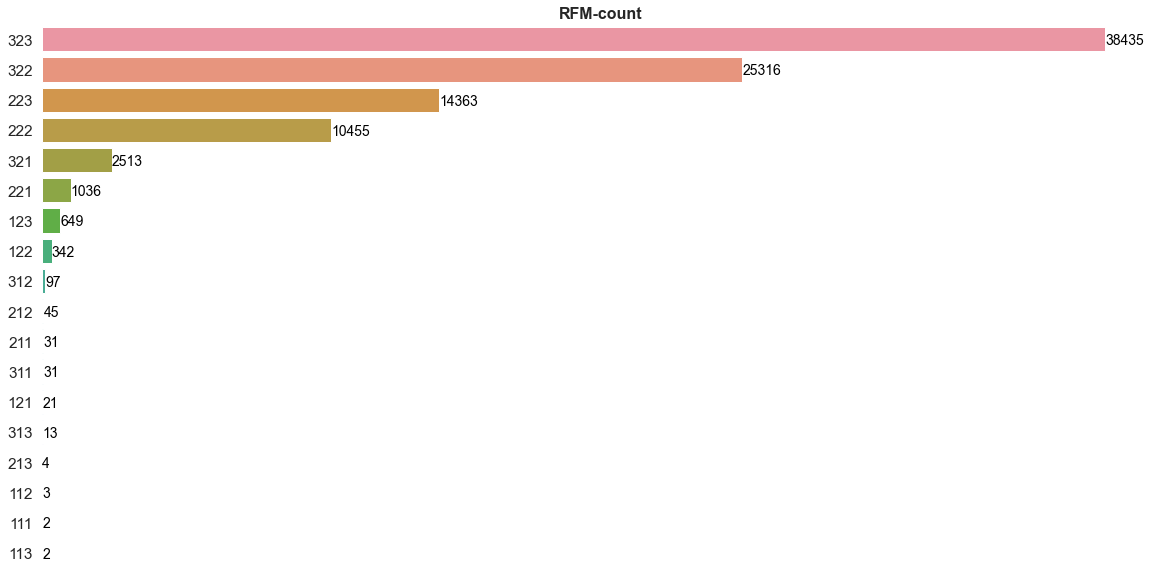

In [326]:
#делим на сегменты
df_rfm_seg['r_seg'] = pd.cut(df_rfm_seg['delta_days'],bins=[0, 60, 180, 900], labels=[1,2,3], right=False)
df_rfm_seg['f_seg'] = pd.cut(df_rfm_seg['order_id'],bins=[0, 1, 3, 30], labels=[3,2,1], right=False)
df_rfm_seg['m_seg'] = pd.cut(df_rfm_seg['price'],bins=[0, 100, 500, 100000], labels=[3,2,1], right=False)

#добавляем общий rfm_score
df_rfm_seg['rfm_score'] = df_rfm_seg.r_seg.astype(str) + df_rfm_seg.f_seg.astype(str) + df_rfm_seg.m_seg.astype(str)

#график отражающий количество пользователей в каждом сегменте
descending_order = df_rfm_seg['rfm_score'].value_counts().sort_values(ascending=False).index
ax = sns.countplot(y = df_rfm_seg['rfm_score'], order=descending_order)

sns.despine(fig=None, ax=None, top=True, right=True, left=False, trim=False)
sns.set(rc={'figure.figsize':(20,10)})

ax.set_ylabel('')    
ax.set_xlabel('')
ax.set_title('RFM-count', fontsize=16, fontweight='heavy')
sns.set(font_scale = 1.4)
ax.axes.get_xaxis().set_visible(False)
ax.set_frame_on(False)

y = df_rfm_seg['rfm_score'].value_counts()
for i, v in enumerate(y):
    ax.text(v + 0.2, i + .16, str(v), color='black', fontweight='light', fontsize=14)



In [327]:
#таблица с процентами каждого сегмента
rfm_count = pd.DataFrame(df_rfm_seg['rfm_score'].value_counts())
rfm_count['percentage'] = round(df_rfm_seg['rfm_score'].value_counts(normalize = True) *100, 3)
rfm_count

,rfm_score,percentage
323,38435,41.169
322,25316,27.117
223,14363,15.385
222,10455,11.199
321,2513,2.692
221,1036,1.110
123,649,0.695
122,342,0.366
312,97,0.104
212,45,0.048


Расшифровка сегментов\
По давности заказа (recency):\
1 — недавние клиенты, которые делали заказ в последние 60 дней.\
2 — относительно недавние клиенты, которые делали заказ в последние 60-180 дней;\
3 — давние клиенты, которые делали заказ более 180 дней назад;\
По частоте покупок (frequency):\
1 — покупает часто, более 3 заказов за все время.\   
2 — покупает нечасто, от 2 до 3 заказов за все время;\
3 — покупает очень редко (единичные заказы), не более 1 заказа за все время;\
По сумме покупок (monetary):\
1 — большая сумма, более 500 уе;\
2 — средняя сумма, от 100 до 500 уе;\
3 — маленькая сумма, до 100 уе.

**Пример.** Самый большой(41%) RFM-сегмент 323 (recency=3, frequency=2, monetary=3), в этот сегмент попали пользователи, которые совершили последнюю покупку более 180 дней назад(recency), при этом всего покупок за весь период было от 1 до 3(frequency) на сумуу до 100 уе(monetary). Этот сегмент давних неактивных клиентов, которые покупали не очень много и на маленькую сумму.\
Самый маленький RFM-сегмент, где всего 2 клиента, 111 (recency=1, frequency=1, monetary=1), в этот сегмент попали пользователи, которые совершили последнюю покупку менее 60 дней назад, при этом всего покупок за весь период было более 3 на сумуу от 1000 уе. Это сегмент активных клиентов, которые недавно покупали много на большую сумму. Этот сегмент наиболее выгодный для компании.

«111» — самые активные клиенты. Можно предложить им что-то ценное, например, золотую карту или приглашение на отраслевое мероприятие для укрепления лояльного отношения.\
«х1х» — покупают немного, но постоянно. Можно предложить сопутствующие товары, бонусную карту или участие в программе лояльности. Нужно попытаться увеличить средний чек.\
«хх1» — покупают редко, но зато на большие суммы. Таким клиентам, возможно, нужно что-то ценное или особенное. Важен индивидуальный подход, чтобы подтолкнуть крупных потребителей на более частые покупки.\
«13х» — новые клиенты, которые в будущем могут стать лояльными. Нужно наладить коммуникацию: поздравить с покупкой, пригласить на сайт или в социальные сети почитать интересные и полезные статьи в блоге и т.п. В целом нужно повысить лояльность.\
«33х» — старые клиенты, активность которых снизилась. Нужно выяснить, почему они перестали совершать покупки? Можно предложить индивидуальные условия, скидки, акции и т.п. Попытаться восстановить отношения и продолжить плодотворное сотрудничество.\
«333» — потерянные клиенты, которые давно не проявляли активность. Нужно попробовать наладить контакт, предложить скидки или специальные предложения. Но если нет отклика, то откажиться от дальнейшей работы. Сосредоточиться на более ценных сегментах.